# A visualization task whose objective was to relax and the result was to pull one's hair out

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from datetime import date
from datetime import datetime
import numpy as np

In [2]:
covid = pd.read_csv(r'casos_hosp_uci_def_sexo_edad_provres.csv')
prv = pd.read_csv(r'provinces_es.csv')

# Exploración y limpieza
## 1.1 Estructura básica

In [3]:
prv.info()
covid.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   code         51 non-null     object
 1   postal_code  52 non-null     int64 
 2   name         52 non-null     object
 3   phone_code   52 non-null     int64 
 4   iso2         52 non-null     object
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


,provincia_iso,sexo,grupo_edad,fecha,num_casos,num_hosp,num_uci,num_def
0,A,H,0-9,2020-01-01,0,0,0,0
1,A,H,10-19,2020-01-01,0,0,0,0
2,A,H,20-29,2020-01-01,0,0,0,0
3,A,H,30-39,2020-01-01,0,0,0,0
4,A,H,40-49,2020-01-01,0,0,0,0


In [4]:
print(prv.columns)

Index(['code', 'postal_code', 'name', 'phone_code', 'iso2'], dtype='object')


## 1.2 Valida duplicados / nulos

In [5]:
covid = covid.drop_duplicates()
covid.isna().mean().sort_values(ascending=False)

,0
provincia_iso,0.018871
sexo,0.000000
grupo_edad,0.000000
fecha,0.000000
num_casos,0.000000
num_hosp,0.000000
num_uci,0.000000
num_def,0.000000


## 1.4 Filtra fechas razonables (ej. 2020–2024)

In [6]:
covid['fecha'] = pd.to_datetime(covid['fecha'], errors='coerce')

# 2. Limpieza mínima
## 2.1. Fechas en formato datetime

In [7]:
covid['fecha'] = pd.to_datetime(covid['fecha'], errors='coerce')

## 2.2. Filas sin 'provincia_iso'  → son totales nacionales/autonómicos.

In [8]:
covid_nacional = covid[covid['provincia_iso'].isna()]
covid_prov     = covid[covid['provincia_iso'].notna()]

# 3. Agregados
## 3.1. Serie Nacional

In [9]:
covid['fecha'] = pd.to_datetime(covid['fecha'], errors='coerce')

In [10]:
# Agrupamos por fecha (nivel nacional: todas las provincias y edades)
serie_nacional = (
    covid.groupby('fecha')[['num_casos', 'num_hosp', 'num_uci', 'num_def']]
         .sum()
         .rolling(7).mean()  # suavizamos con media móvil de 7 días
)

## 3.2. Casos por provincia y fecha

In [11]:
prv = prv.rename(columns={'code': 'provincia_iso', 'name': 'provincia'})  # ajusta nombres
covid = covid.merge(prv[['provincia_iso', 'provincia']], on='provincia_iso', how='left')

In [12]:
casos_por_prov_dia = (
    covid.groupby(['fecha', 'provincia'])['num_casos']
         .sum()
         .reset_index()
)

# Pivot para heatmap (provincias como filas, fechas como columnas)
heatmap_data = casos_por_prov_dia.pivot(index='provincia', columns='fecha', values='num_casos')

## 3.3. Letalidad por grupo de edad

In [13]:
letalidad = (
    covid.groupby('grupo_edad')
         .agg(muertes=('num_def', 'sum'),
              casos=('num_casos', 'sum'))
         .assign(ifr=lambda df: df['muertes'] / df['casos'])
         .sort_values('ifr', ascending=False)
)

# 4. Visualizaciones
## 4.1 · Serie nacional evolución temporal

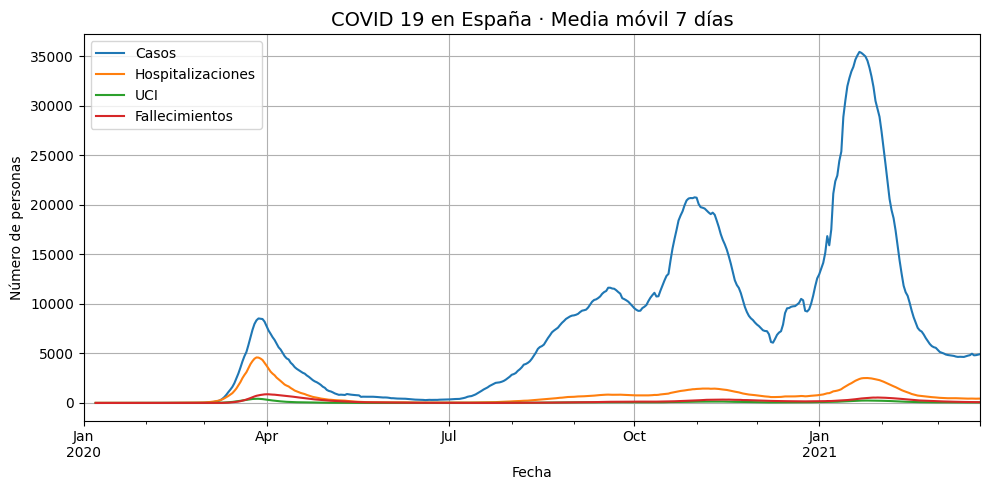

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))

serie_nacional.plot(ax=ax, linewidth=1.5)
ax.set_title('COVID 19 en España · Media móvil 7 días', fontsize=14)
ax.set_xlabel('Fecha')
ax.set_ylabel('Número de personas')
ax.legend(['Casos', 'Hospitalizaciones', 'UCI', 'Fallecimientos'], loc='upper left')
ax.grid(True)
plt.tight_layout()
plt.show()

Se observa un fuerte incremento de casos durante finales de 2020 e inicios de 2021, coincidiendo con la llamada tercera ola.

A partir de mediados de 2021, la evolución muestra picos más suaves, lo que sugiere un impacto positivo de la vacunación.

Las muertes y hospitalizaciones siguen una evolución similar a la de los casos, con cierto retardo temporal.

## 4.2 · Heatmap de casos por provincia

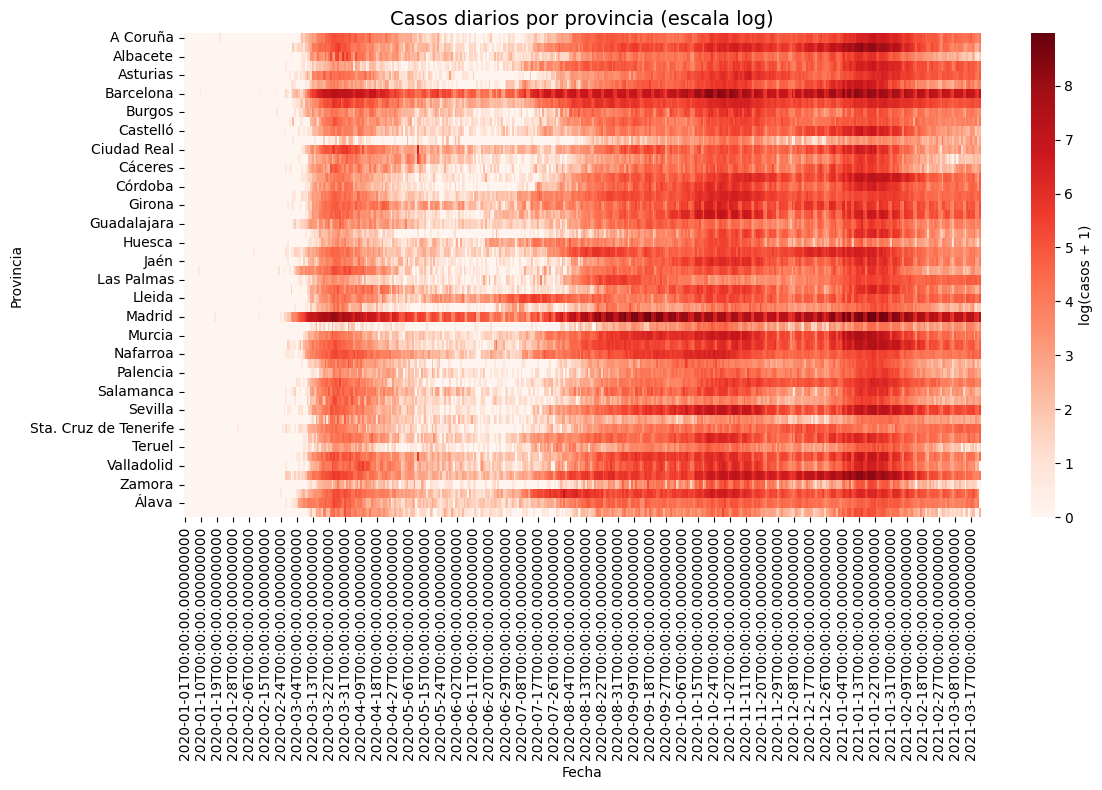

In [15]:
plt.figure(figsize=(12, 8))

# Asegúrate de que provincias estén ordenadas alfabéticamente o por total acumulado
heatmap_sorted = heatmap_data.fillna(0).apply(np.log1p)  # log(1 + x) para evitar log(0)

sns.heatmap(heatmap_sorted, cmap='Reds', cbar_kws={'label': 'log(casos + 1)'})
plt.title('Casos diarios por provincia (escala log)', fontsize=14)
plt.xlabel('Fecha')
plt.ylabel('Provincia')
plt.tight_layout()
plt.show()

Se identifican olas de contagios sincrónicas, pero también algunas provincias con picos desfasados (por ejemplo, provincias insulares como Baleares o Canarias).

El heatmap permite observar la estacionalidad y la repetición de patrones de aumento de casos entre invierno y verano.

## 4.3 · Letalidad por grupo de edad

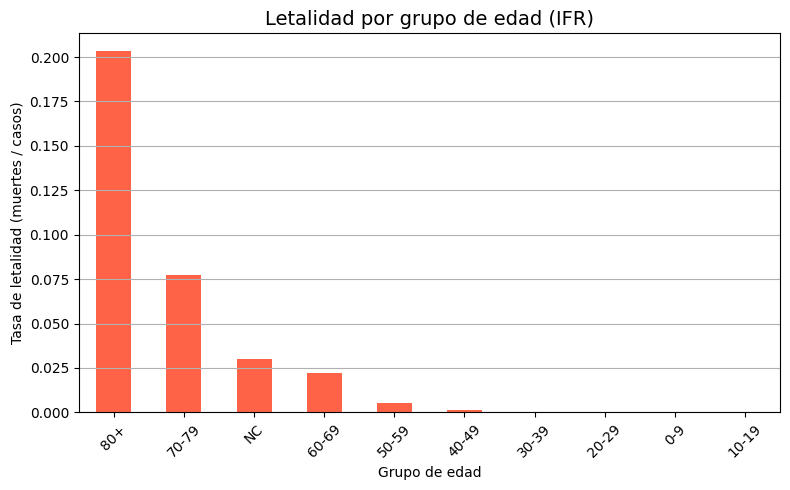

In [16]:
plt.figure(figsize=(8, 5))
letalidad['ifr'].plot(kind='bar', color='tomato')

plt.title('Letalidad por grupo de edad (IFR)', fontsize=14)
plt.ylabel('Tasa de letalidad (muertes / casos)')
plt.xlabel('Grupo de edad')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

La letalidad (IFR) se incrementa drásticamente a partir del grupo 70-79 años, y es especialmente alta en 80+.

Los menores de 50 años tienen una letalidad muy baja, prácticamente nula en los más jóvenes.

## 4.4. Letalidad por provincias

In [17]:
import geopandas as gpd

In [19]:
provincias = gpd.read_file("spain-provinces.geojson")

In [ ]:
# Para mayor simplicidad voy a usar los isos
tabla_iso = prv[['provincia_iso', 'provincia']].dropna().drop_duplicates()

In [23]:
provincias = provincias.merge(tabla_iso, left_on='name', right_on='provincia', how='left')


In [24]:
muertes_por_iso = (
    covid.groupby('provincia_iso')['num_def']
         .sum()
         .reset_index()
)

In [25]:
provincias = provincias.merge(muertes_por_iso, on='provincia_iso', how='left')

<Axes: >

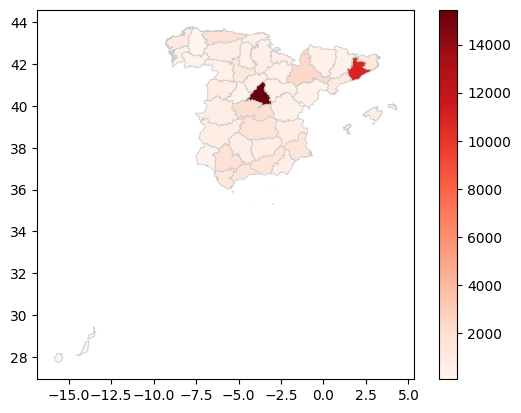

In [26]:
provincias.plot(
    column='num_def',
    cmap='Reds',
    legend=True,
    edgecolor='0.8',
    linewidth=0.6
)

# A continuación vamos a hacerlo interactivo

Las provincias con mayor número absoluto de muertes acumuladas son Madrid, Barcelona, Valencia y Sevilla.

Se detectan diferencias significativas incluso dentro de la misma comunidad autónoma, lo que sugiere factores locales (densidad, movilidad, edad media).

In [27]:
provincias = provincias.merge(tabla_iso, left_on='name', right_on='provincia', how='left')

In [28]:
provincias = provincias.rename(columns={'provincia_iso_x': 'provincia_iso'})

In [29]:
provincias_limpio = provincias[['provincia_iso', 'num_def', 'geometry']].copy()
provincias_limpio.to_file("provincias_con_iso.geojson", driver='GeoJSON')

In [33]:
import json
import plotly.express as px

# Cargar GeoJSON como archivo externo
with open("provincias_con_iso.geojson", encoding="utf-8") as f:
    geojson_data = json.load(f)

# Usar Plotly con ese GeoJSON
fig = px.choropleth(
    provincias,
    geojson=geojson_data,
    locations='provincia_iso',
    featureidkey="properties.provincia_iso",  # <- ¡MUY IMPORTANTE!
    color='num_def',
    hover_name='provincia_iso',
    color_continuous_scale="Reds",
    labels={'num_def': 'Muertes'},
    title="COVID-19: Muertes por provincia (interactivo)"
)

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig.show()